<a href="https://colab.research.google.com/github/ncsu-geoforall-lab/geomorphometry2025_workshop/blob/main/geomorphometry_2025_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop: Propagating DEM Uncertainty to Stream Extraction using GRASS

### Abstract

GRASS is an open-source geospatial processing engine. With over 400 tools available in the core distribution and an additional 400+ tools available as extensions, GRASS has broad applicability in the Earth Sciences and geomorphometry in particular. In this workshop, we will give an introduction to GRASS and demonstrate some of the geomorphometry tools available in GRASS. Specifically, we will show how to compute stream extraction uncertainty using a workflow adapted from Hengl (2007) [1] and Hengl (2010) [2]. In this tutorial, we will:
* [Create a new GRASS project](#start)
* [Download and import elevation data](#data) of near Perugia using GRASS data fetching tools
* [Use R’s kriging functions (gstat)](#R) to create 100 iterations of a DEM
* Use GRASS tools to extract streams from each of the 100 DEMs to compute stream uncertainty

Check out the publication associated with the notebook on Zenodo:

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.15283714.svg)](https://doi.org/10.5281/zenodo.15283714)


<a name="start"></a>

---


### Start GRASS and Create a New Project

The following cell installs GRASS from the ubuntugis-unstable ppa. It will take a minute to run.

In [3]:
!add-apt-repository -y ppa:ubuntugis/ubuntugis-unstable
!apt update
!apt-get install -y grass-core grass-dev

PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntugis/ubuntugis-unstable/ubuntu/ jammy main'
Description:
Unstable releases of Ubuntu GIS packages. These releases are more bleeding edge and while generally they should work well, they dont receive the same amount of quality assurance as our stable releases do.
More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ubuntugis-unstable
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ubuntugis-unstable-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ubuntugis-unstable-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntugis-ubuntu-ubuntugis-unstable.gpg with fingerprint 2EC86B48E6A9F326623CD22FFF0E7BBEC491C6A1
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]

We can check GRASS installed and see what version we have using:

In [4]:
!grass --version

GRASS GIS 8.4.1
Geographic Resources Analysis Support System (GRASS) is Copyright,
1999-2025 by the GRASS Development Team, and licensed under terms of the
GNU General Public License (GPL) version >=2.

This GRASS GIS 8.4.1 release is coordinated and produced by
the GRASS Development Team with contributions from all over the world.

This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
General Public License for more details.


In [45]:
!git clone https://github.com/ncsu-geoforall-lab/geomorphometry2025_workshop.git

Cloning into 'geomorphometry2025_workshop'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 182 (delta 70), reused 132 (delta 38), pack-reused 0 (from 0)
Receiving objects: 100% (182/182), 14.29 MiB | 23.71 MiB/s, done.
Resolving deltas: 100% (70/70), done.


Import Python libraries.

In [5]:
import sys
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Image
from ipyleaflet import ImageService, WMSLayer, Marker
from ipyleaflet.projections import projections
import xyzservices

We are going to import the GRASS Python API (`grass.script`) and the GRASS Jupyter package (`grass.jupyter`). But first, we'll need to ask `grass` to check it's `--config` to see where the python packages are then add them to the system path before we can import them.

We use `subprocess.check_output` to find the path and `sys.path.append` to add it to the path.

In [6]:
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

Then, we can import the Python API and GRASS Jupyter packages.

In [7]:
import grass.script as gs
import grass.jupyter as gj

Now, we create a new project called "geomorphometry_workshop". Projects are defined by a Coordinate Reference System (CRS). We can set the CRS from a georeferenced file (such as a Geotiff) or an EPSG string. Here, we use [EPSG 32632](https://epsg.io/32632), CRS WGS 84/UTM zone 32N (EPSG:32632).

In [8]:
gs.create_project("geomorphometry_workshop", epsg="32632")

We start a GRASS session in our new project.

In [9]:
gj.init("geomorphometry_workshop");

Finally, let's set our computational region using [`g.region`](https://grass.osgeo.org/grass85/manuals/g.region.html). The computational region will determine what data is imported from the cloud so we need to set it before continuing.

Upon creating a project, the computational region is empty.

In [10]:
print(gs.read_command("g.region", flags="p"))

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      1
south:      0
west:       0
east:       1
nsres:      1
ewres:      1
rows:       1
cols:       1
cells:      1



There are lots of ways to set the computional region, from a georeferenced file or existing data layer to relative operations grow which adds cells around the previous region. Here, we set our computational region with coordinates and set the resolution to 10 meters.

In [11]:
aoi_bbox = {
	"north": 4779210,
	"south": 4778120,
	"west": 779180,
	"east": 780630
}

print(
    gs.read_command(
        "g.region", n=aoi_bbox["north"], s=aoi_bbox["south"], e=aoi_bbox["east"], w=aoi_bbox["west"], res=10, flags="p"
    )
)

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4779210
south:      4778120
west:       779180
east:       780630
nsres:      10
ewres:      10
rows:       109
cols:       145
cells:      15805



<a name="data"></a>

---

## Download and Import Data

We're going to use a DEM from the TINItaly dataset. Let's get an overview of the dataset using a quick WMS visualization.

In [12]:
tinitaly_wms = WMSLayer(
    name="TINItaly_1.1 HSV (WMS)",
    url="http://tinitaly.pi.ingv.it/TINItaly_1_1/wms?service=WMS",
    layers="TINItaly_1.1:tinitaly_hsv",
    format="image/png",
    transparent=True,
    attribution="HSV Elevation Data © 2023 TINItaly 1.1",
)

tinitaly_slope = WMSLayer(
    name="TINItaly_1.1 Slope (WMS)",
    url="http://tinitaly.pi.ingv.it/TINItaly_1_1/wms?service=WMS",
    layers="TINItaly_1.1:tinitaly_slope",
    format="image/png",
    transparent=True,
    attribution="Slope Data © 2023 TINItaly 1.1",
)

nasa_wms = WMSLayer(
    name="NASA SRTM RAMP2 TOPO (WMS)",
    url="https://neo.gsfc.nasa.gov/wms/wms?service=WMS",
    layers="SRTM_RAMP2_TOPO",
    format="image/png",
    transparent=True,
    styles="rgb",
    attribution="SRTM RAMP2 TOPO © 2025 NASA ",
)

perugia = Marker(
    name="Perugia (Marker)",
    location=(43.11203, 12.38914),
    draggable=False,
    title="Perugia",
    alt="Perugia",
    # icon="fa-flag",
)

In [13]:
nasa_basemap = "NASAGIBS BlueMarble"
m = gj.InteractiveMap(height=600, width=800, tiles=nasa_basemap, use_region=True)
m.map.add(tinitaly_wms)
m.map.add(tinitaly_slope)
m.map.add(nasa_wms)
m.map.add(perugia)
m.add_layer_control()
m.map.zoom = 6
m.map.center = (43.11203, 12.38914)
display(m.show())

Map(center=[43.11203, 12.38914], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

Now we can import our DEM. We will use the [r.import](https://grass.osgeo.org/manuals/grass85/r.import.html) command to import a DEM file. The DEM file is a [Cloud Optimized GeoTIFF (COG)](https://cogeo.org/), and we will specify the output name as "dem". *r.import* will automatically reproject the DEM to the project's CRS.

In [14]:
gs.run_command(
    "r.import",
    input="https://storage.googleapis.com/geomorphometry/w47575_s10.cog.tif",
    output="dem",
    title="TINItaly DEM 10m",
    resample="bicubic_f",
    resolution="region",
    extent="region",
    overwrite=True,
)

Let's get some basic information about our DEM. We'll use the [`r.info`](https://grass.osgeo.org/grass85/manuals/r.info.html) and [`r.univar`](https://grass.osgeo.org/grass85/manuals/r.univar.html) tools to get the rasters metadata and univariate statistics respectively.

In [15]:
print(gs.read_command("r.info", map="dem"))

 +----------------------------------------------------------------------------+
 | Map:      dem                            Date: Tue May  6 15:29:31 2025    |
 | Mapset:   PERMANENT                      Login of Creator: root            |
 | Project:  geomorphometry_workshop                                          |
 | DataBase: /content                                                         |
 | Title:                                                                     |
 | Timestamp: none                                                            |
 |----------------------------------------------------------------------------|
 |                                                                            |
 |   Type of Map:  raster               Number of Categories: 0               |
 |   Data Type:    FCELL                Semantic label: (none)                |
 |   Rows:         109                                                        |
 |   Columns:      145                  

**Try it yourself!**

Using the cell above as a template, compute the univariate statistics using [`r.univar`](https://grass.osgeo.org/grass85/manuals/r.univar.html).

<details>
    <summary>👉 <b>click to see hint</b></summary>
  
Run `!r.univar --help` to see the paramters.
</details>


<details>
    <summary>👉 <b>click to see solution</b></summary>
    
```python
print(gs.read_command("r.univar", map="dem", flags="e"))
```
</details>


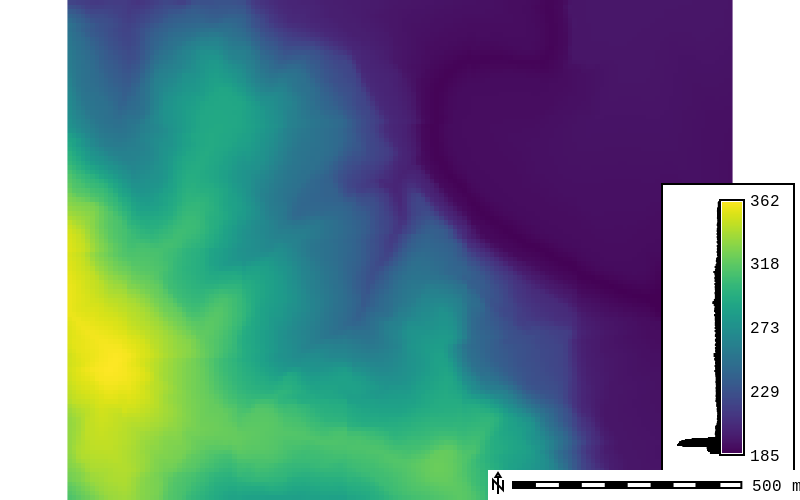

In [17]:
m = gj.Map(use_region=True, height=500, width=800)
m.d_rast(map="dem")
m.d_legend(raster="dem", flags="bds", at="9,60,90,93", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

Compute some other common DEM derivatives: shaded relief, slope and aspect.

In [30]:
gs.run_command("r.relief", input="dem", output="relief", scale=1, zscale=1)

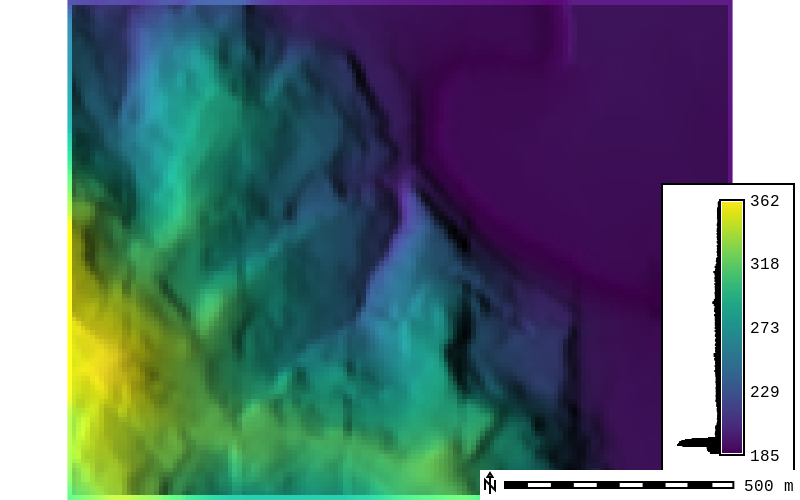

In [31]:
m = gj.Map(use_region=True, height=500, width=800)
m.d_shade(shade="relief", color="dem", brighten=30)
m.d_legend(raster="dem", flags="bds", at="9,60,90,93", fontsize=16)
m.d_barscale(at="60,6", fontsize=16, flags="n")
m.show()


In [32]:
gs.run_command("r.slope.aspect", elevation="dem", slope="slope", aspect="aspect", overwrite=True)

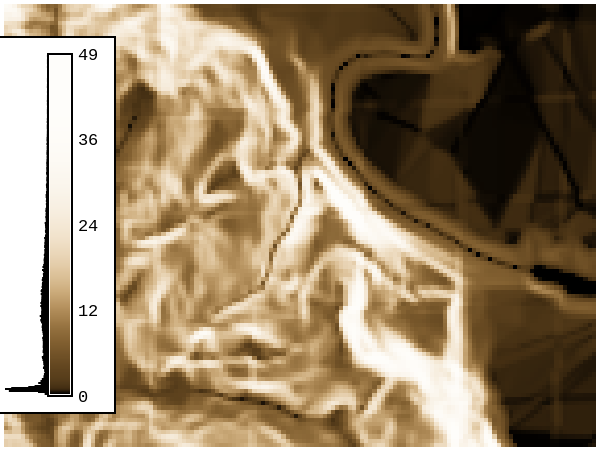

In [33]:
gs.run_command("r.colors", map="slope", color="sepia", flags="e")

m = gj.Map(use_region=True)
m.d_rast(map="slope")
m.d_legend(raster="slope", flags="bds")
m.show()

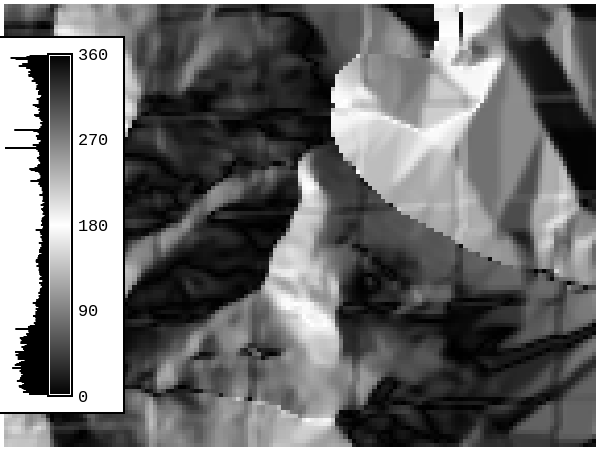

In [34]:
m = gj.Map(use_region=True)
m.d_rast(map="aspect")
m.d_legend(raster="aspect", flags="bds")
m.show()

Since we're going to interpolate surfaces from points, we'll randomly sample points from the DEM. We could think of these as LiDAR points or ground sampled points.

In [35]:
gs.run_command("r.random", input="dem", vector="elevrand", n=1000, flags="s")

Now, visualize the points.

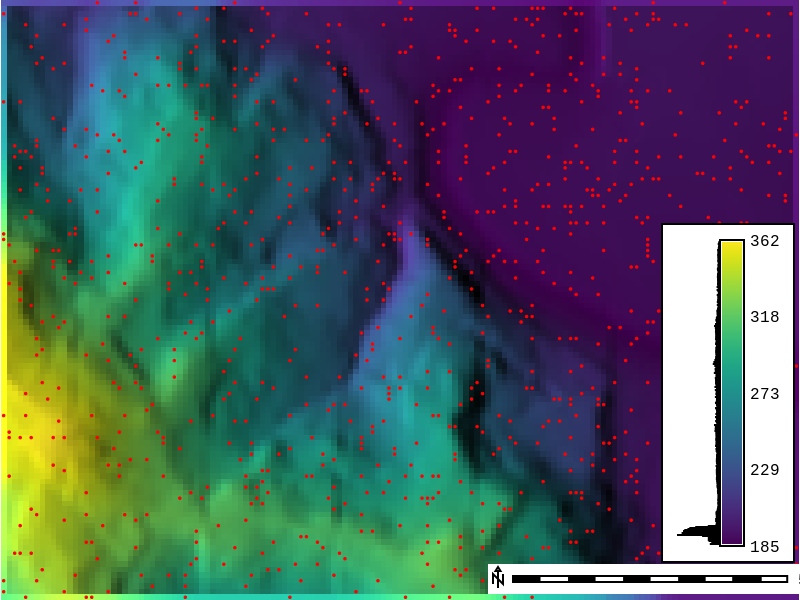

In [38]:
m = gj.Map(use_region=True, height=600, width=800)
m.d_shade(shade="relief", color="dem", brighten=30)
m.d_vect(map="elevrand", color="red", fillcolor="red", icon="basic/point")
m.d_legend(raster="dem", flags="bds", at="9,60,90,93", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()



<a name="R"></a>

---

## Conditional Gaussian Kriging in R


Load rpy2 extension. rpy2 is an interface to R running embedded in a Python process allowing up to continue operating in our current Python session but cells in R.

In [39]:
%load_ext rpy2.ipython

Now, we can use the %%R cell magic. When this cell is interpreted, it's contents will be sent to R. We could also use line magic now with %R which would only send the line to R.

In [41]:
%%R
system("apt-get install r-cran-sf r-cran-rgrass r-cran-gstat r-cran-terra r-cran-devtools r-cran-irkernel")

We also need some other function to help parameterize our Matern Covariance variogram. Dr. Corey White has drafted a package to help with this. We load it here:

In [46]:
%%R
devtools::load_all("geomorphometry2025_workshop/cgsSim/")

ℹ Loading cgsSim
ℹ The packages "future", "future.apply", "optparse", and "rgrass" (>= 0.4-2) are required.
✖ Would you like to install them?

1: Yes
2: No

Selection: Yes
future       (NA -> 1.40.0) [CRAN]
rgrass       (NA -> 0.5-2 ) [CRAN]
optparse     (NA -> 1.7.5 ) [CRAN]
future.apply (NA -> 1.11.3) [CRAN]


Installing 4 packages: future, rgrass, optparse, future.apply
Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘globals’, ‘listenv’, ‘parallelly’, ‘getopt’

trying URL 'https://cran.rstudio.com/src/contrib/globals_0.17.0.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/listenv_0.9.1.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/parallelly_1.43.0.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/getopt_1.20.4.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/future_1.40.0.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/rgrass_0.5-2.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/optparse_1.7.5.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/future.apply_1.11.3.tar.gz'

The downloaded source packages are in
	‘/tmp/Rtmp81ACfS/downloaded_packages’
cgsSim 0.1.0


Load other libraries.

In [48]:
%%R
library(sf)
library(gstat)
library(terra)
library(rgrass)

Use readVECT from rgrass to turn the random elevation points into a [SpatVector](https://rdrr.io/cran/terra/man/SpatVector-class.html), the terra vector class.

In [49]:
%%R
elevrand <- rgrass::read_VECT("elevrand")

Exporting 1000 features...
   5%  11%  17%  23%  29%  35%  41%  47%  53%  59%  65%  71%  77%  83%  89%  95% 100%
v.out.ogr complete. 1000 features (Point type) written to <elevrand> (GPKG
format).


Compute the cutoff and width of the empirical variogram by using the maximum distance between two points. CITATION?

In [50]:
%%R

coords <- terra::geom(elevrand)[, c("x", "y")]
dists <- as.matrix(dist(coords))
max_dist <- max(dists)

# Best practice
# Default cutoff is 0.5 but this is too small for our data
cutoff <- 0.9 * max_dist
width <- cutoff / 15
print(paste("Using cutoff:", cutoff, "and width:", width))

[1] "Using cutoff: 1596.68218503245 and width: 106.445479002163"


With the width and cutoff, we can computate the variogram. First, convert to random sample points to an `sf` dataframe since that is the input format for `gstat`.

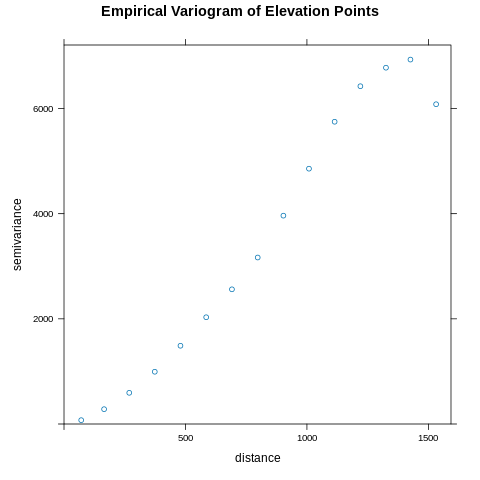

In [52]:
%%R
elev_df <- terra::as.data.frame(elevrand, geom = "XY")
# saveRDS(elev_df, file = "cgsSim/data/dataframe.rds")
g <- gstat::gstat(formula = value ~ 1, locations = ~x + y, data = elev_df)
# saveRDS(g, file = "cgsSim/data/gstat.rds")

vg <- gstat::variogram(g, cutoff = cutoff, width = width)
# saveRDS(vg, file = "cgsSim/data/variorgram.rds")

plot(vg, main = "Empirical Variogram of Elevation Points")

Now, we're going to fit a Matern Covariance function to the empirical variogram. First, we'll fit Kappa using `cgSim` library that Dr. Corey White has been working on. We pass the empirical variogram as the input.

In [53]:
%%R
# Fit kappa
fit_kappa <- optimize_kappa(vg)
fit_kappa

$model
  model       psill    range     kappa
1   Nug    18.35458    0.000 0.0000000
2   Mat 94976.10673 5263.724 0.9353753

$kappa
[1] 0.9353753

$SSErr
[1] 10447.48



In addition: Warning message:
In gstat::fit.variogram(vg, model = gstat::vgm(model = "Mat", nugget = NA,  :
  No convergence after 200 iterations: try different initial values?


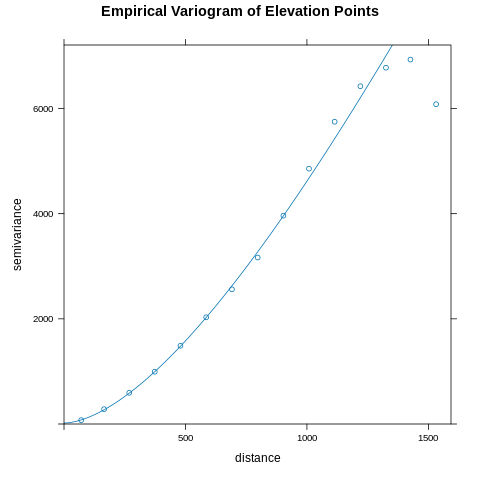

In [54]:
%%R
plot(vg, model = fit_kappa$model, main = "Empirical Variogram of Elevation Points")

In [56]:
%%R
# Fit variogram automatically: THIS TAKES SO LONG
fit_result <- auto_variogram_fit(elev_df, cutoff = cutoff, width = width, kappa = fit_kappa$kappa)

Streaming output truncated to the last 5000 lines.
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]

Let's see some information about our fitted variogram:

In [57]:
%%R
head(fit_result)

$psill
psill_start 
   1298.233 

$range
range_start 
   1297.991 

$nugget
nugget_start 
    25.96465 

$kappa
[1] 0.9353753

$mse
[1] 4.492963

$vgm_model
  model      psill    range     kappa
1   Nug   25.96465    0.000 0.0000000
2   Mat 1298.23259 1297.991 0.9353753



And plot the fitted variogram alonside the empirical variogram.

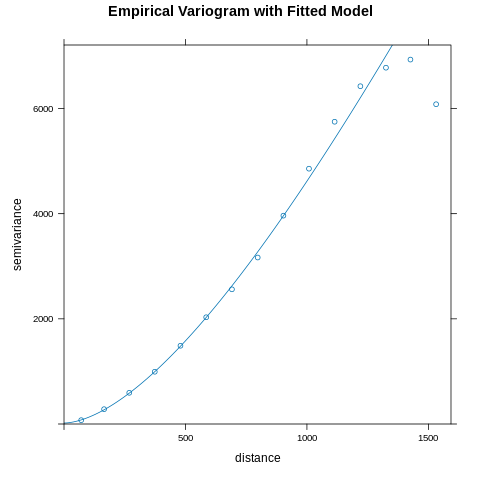

In [58]:
%%R
plot_auto_variogram(vg, fit_result$vgm_model)

In [ ]:
# WHAT'S THIS
# vfit <- gstat::fit.variogram(vg, model = fit_result$vgm_model, fit.kappa = FALSE)
vfit <- gstat::fit.variogram(vg, model = vgm_model, fit.kappa = FALSE)

Time to interpolate our DEMs using the fitted variogram. We will only do 10 simulations since the process is computationally intensive but in the GitHub repo, we've included a set of 90 pre-computed simulations that we'll import after this for computed extracted stream uncertainty.

Create a 10m resolution grid for prediction:

In [60]:
%%R
grid_ext <- terra::ext(elevrand)
grid_res <- 10

xy <- expand.grid(
  x = seq(grid_ext[1], grid_ext[2], by = grid_res),
  y = seq(grid_ext[3], grid_ext[4], by = grid_res)
)

Run 10 stochastic conditional gaussian simulations, creating 10 DEMs. The `run_sim` tool is part of `cgSim` which uses `gstat::predict` on the backend.

In [ ]:
%%R
run_sim(
  elev_df,
  fitmodel = vfit,
  nsim = 10,
  newdata=xy,
  nmin = 10,
  nmax = 40,
  distmax = cutoff,
)

The `run_sim` function writes these rasters into GRASS. Use the GRASS R API to list the simulated rasters:

In [ ]:
execGRASS("g.list", type="raster", pattern="sgs_sim_*")

Import the other 90 simulations:

Calculate the mean and standard deviation of the simulatate surfaces

In [ ]:
%%R
execGRASS("g.list", type="raster", pattern="sgs_sim_*", output="tmp_list_simulated.txt")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_mean", method="average")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_std", method="stddev")

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


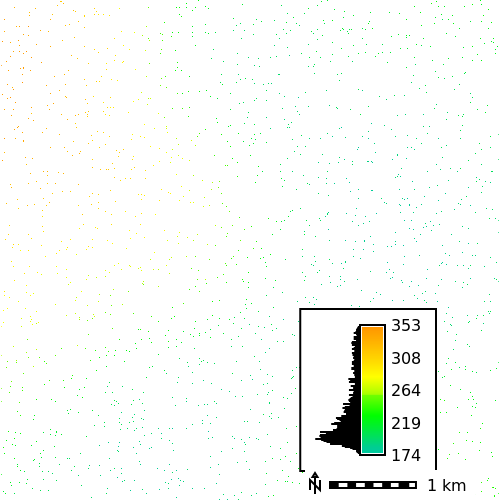

In [ ]:
m = gj.Map(use_region=True, height=500, width=500)
m.d_rast(map="simulated_mean")
m.d_legend(raster="simulated_mean", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

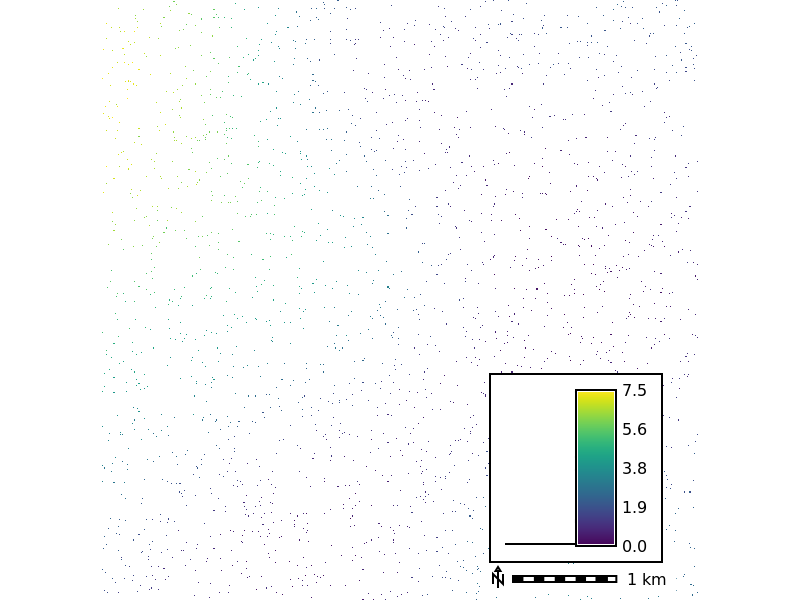

In [ ]:
m = gj.Map(use_region=True, height=600, width=800)
m.d_rast(map="simulated_mean")
m.d_legend(raster="simulated_std", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

---

## Extract Streams and Compute Uncertainty

Generate streams for each DEM

In [ ]:
%%R
N.sim <- 10
for(i in 1:N.sim) {execGRASS("r.watershed", elevation=paste("sgs_sim_", i, sep=""),
 threshold=10000, stream=paste("stream_", i, sep=""), flags=c("quiet"))}

Calculate the probablity and error

INSERT EQUATION AND CITATION

In [ ]:
%%R
execGRASS("g.list", type="raster", pattern="stream*", output="tmp_list_stream.txt")
execGRASS("r.series", file="tmp_list_stream.txt", output="count", method="count")
execGRASS("r.mapcalc", expression=paste("prob = float(count)/", N.sim))
execGRASS("r.mapcalc", expression="error = -prob * log(prob) - (1-prob)* log(1-prob)")

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


Probability that a cell contains a stream:

In [ ]:
m =gj.Map()
m.d_shade(shade="relief", color="prob", brighten=30)
m.show()

Stream error:

In [ ]:
m =gj.Map()
m.d_shade(shade="relief", color="error", brighten=30)
m.show()


---

## OLD CODE

This works in CoLab but not locally at the moment.

In [ ]:
%%R

# Objective function: SSErr for each kappa
fit_variogram_sserr <- function(kappa) {
  base::attr(gstat::fit.variogram(vg, gstat::vgm(model = "Mat", kappa = kappa)), "SSErr")
}

# Range of kappa values to try
kappa_vals <- base::seq(0.1, 5, by = 0.1)

# # Compute SSErr for each value
sserr_vals <- base::sapply(kappa_vals, fit_variogram_sserr)

# # Optimize for best kappa
opt_result <- optimize(fit_variogram_sserr, c(0.1, 5))

best_kappa <- opt_result$minimum
best_sserr <- opt_result$objective

# # Plot SSErr vs. kappa
# plot(kappa_vals, sserr_vals, type = "b", pch = 16,
#      xlab = expression(kappa), ylab = "Sum of Squared Errors",
#      main = "SSErr vs. Matérn Smoothness (kappa)")

# # Add vertical line at best kappa
# abline(v = best_kappa, col = "grey", lty = 2)

# # Label the optimal point
# text(x = best_kappa, y = best_sserr, labels = paste0("kappa = ", round(best_kappa, 3)),
#      pos = 3, offset = 5, col = "blue")

In [ ]:
%%R

# Create 10m resolution grid for prediction
grid_ext <- terra::ext(elevrand)
grid_res <- 10

xy <- expand.grid(
  x = seq(grid_ext[1], grid_ext[2], by = grid_res),
  y = seq(grid_ext[3], grid_ext[4], by = grid_res)
)

# Convert to sf POINT geometry
xy_sf <- sf::st_as_sf(xy, coords = c("x", "y"))


# Recreate gstat object using sf
g <- gstat::gstat(
  formula = value ~ 1,
  data = elev_df,
  model = vfit,
  locations=~x+y
)


### Saving this for now might use later

In [ ]:
%%R
g <- gstat::gstat(
  formula = value ~ 1,
  data = elev_df,
  model = vfit,
  locations = ~x + y,
  nmin=10,
  nmax=250,
  maxdist=400
)
# Number of SGS realizations
N.sim <- 4

# Output file prefix
output_prefix <- "sgs_sim"

raster_list <- list()

# Run SGS simulations
for (i in 1:N.sim) {
  cat("Simulating realization", i, "...\n")

  # Perform simulation
  sim <- predict(g, newdata = xy_sf, nsim = 1, debug.level = -1)

  # Extract the simulated values
  sim_values <- sim$sim1

  # Add simulated values to the grid
  xy_sf$sim <- sim_values

  # Convert to SpatRaster
  sim_rast <- terra::rast(xy_sf, crs = terra::crs(elevrand))

  # Rename layer
  names(sim_rast) <- paste0("sim_", i)

  # Save to GRASS raster
  out_file <- paste0(output_prefix, "_", i)
  rgrass::write_RAST(sim_rast, out_file)

  # Store in list
  raster_list[[i]] <- sim_rast
}

# Stack all results if needed
r_stack <- terra::rast(raster_list)

# Plot one realization
terra::plot(r_stack[[1]])

In [ ]:
%%R
# Stack all results if needed
r_stack <- terra::rast(raster_list)

# Plot one realization
terra::plot(r_stack)

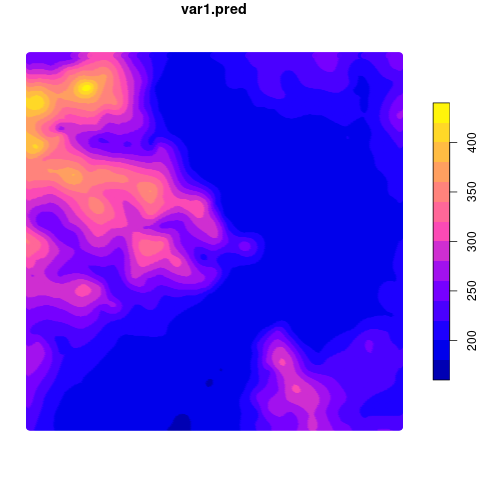

In [ ]:
%%R

z_sf <- st_as_sf(z, coords = c("x", "y"), crs = crs(elevrand))

plot(z_sf["var1.pred"])

In [ ]:
%%bash

r.colors simulated_mean rast=dem
r.colors sgs_sim_10 rast=dem
r.colors simulated_std co=bcyr -e
r.colors aspect_10 co=aspect
r.slope.aspect simulated_mean slo=slp_mean asp=asp_mean
r.slope.aspect sgs_sim_10 slo=slp_10 asp=asp_10
r.mapcalc "diff_spline_gsim = dem - simulated_mean"
r.colors diff_spline_gsim co=differences

Color table for raster map <simulated_mean> set to 'dem'
Color table for raster map <sgs_sim_10> set to 'dem'
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Color table for raster map <simulated_std> set to 'bcyr'
ERROR: Raster map <aspect_10> not found
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Aspect raster map <asp_mean> complete
Slope raster map <slp_mean> complete
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Aspect raster map <asp_10> complete
Slope raster map <slp_10> complete
Color table for raster map <diff_spline_gsim> set to 'differences'


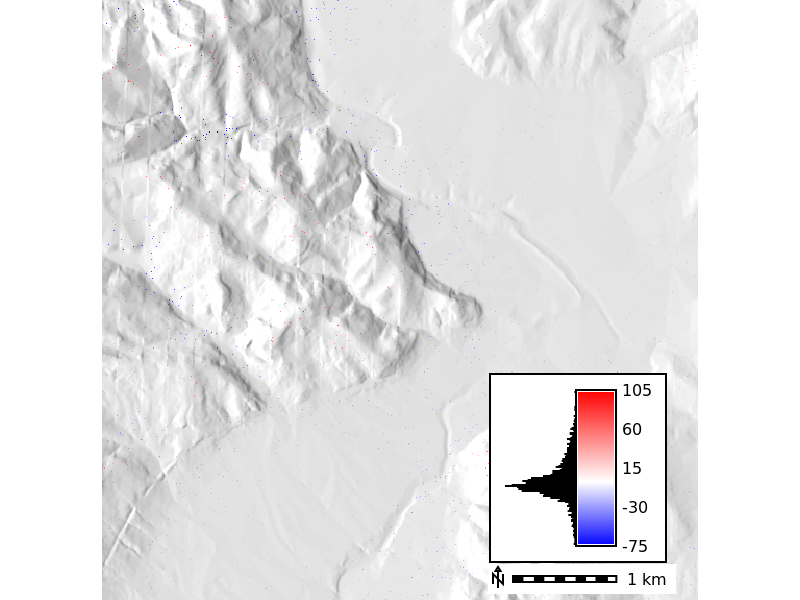

In [ ]:
m = gj.Map(use_region=True, height=600, width=800)
m.d_shade(shade="relief", color="diff_spline_gsim", brighten=30)
m.d_legend(raster="diff_spline_gsim", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

Checking GDAL data type and nodata value...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Using GDAL data type <Float32>
Exporting raster data to RRASTER format...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
r.out.gdal complete. File </tmp/Rtmp8OOieZ/file1ce84e1f9a8a.grd> created.


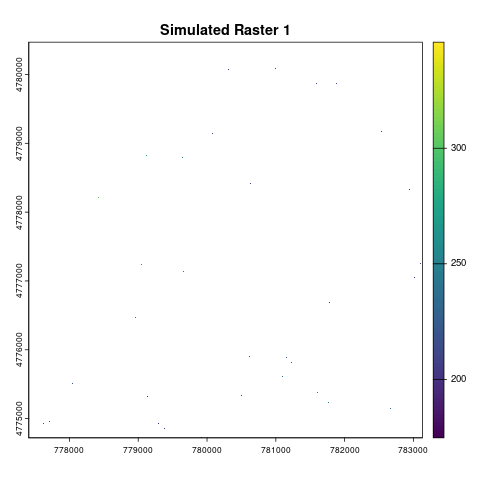

In [ ]:
%%R
sgs_sim_1 <- rgrass::read_RAST("sgs_sim_1")
plot(sgs_sim_1, main = "Simulated Raster 1")

Original Workflow:

https://github.com/ncsu-geoforall-lab/GIS714-assignments/blob/main/Surface_Water_Simulations/WaterSim-Geostatistical-Simulations.ipynb

TUTORIAL Option:

https://geobgu.xyz/r/spatial-interpolation-of-point-data.html